In [1]:
# Essential libraries for data handling, visualization, and modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DBSCAN and data generation
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# For evaluation
from sklearn.metrics import silhouette_score

import warnings 
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Generate a synthetic "moons" dataset, well-suited for DBSCAN
X, y = make_moons(
    n_samples=500, noise=0.07, random_state=27
)

# Create a DataFrame for consistency
df = pd.DataFrame(
    X, columns=['feature_1', 'feature_2']
)
df['true_label'] = y

# Preview the data
df.head()

,feature_1,feature_2,true_label
0,0.935680,0.408027,0
1,1.935616,0.425880,1
2,1.495578,-0.310207,1
3,1.024910,0.270916,0
4,1.491663,-0.197706,1


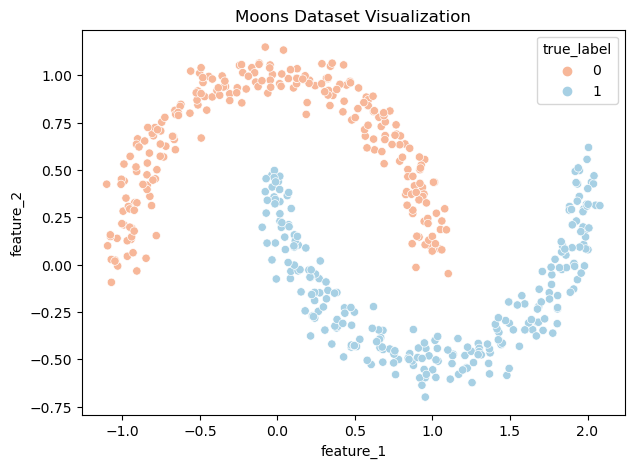

In [4]:
# Visualize the raw data and true labels
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x='feature_1'
    , y='feature_2'
    , hue='true_label'
    , palette='RdBu'
    , data=df
)
plt.title('Moons Dataset Visualization')
plt.show();

,feature_1,feature_2,true_label
0,0.935680,0.408027,0
1,1.935616,0.425880,1
2,1.495578,-0.310207,1
3,1.024910,0.270916,0
4,1.491663,-0.197706,1
...,...,...,...
495,0.368494,-0.151010,1
496,0.960976,0.325571,0
497,0.421455,-0.310831,1
498,-0.773804,0.712314,0


In [10]:
# Scale features for DBSCAN (important for distance-based algorithms)
scaler = StandardScaler()

df[['feature_1', 'feature_2']] = scaler.fit_transform(
    df[['feature_1', 'feature_2']]
)
# scaled_X

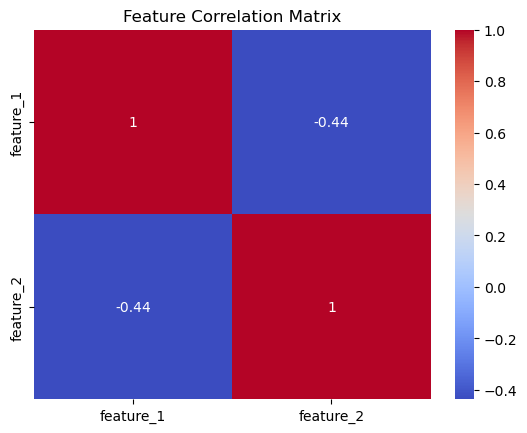

In [11]:
# Check if features are correlated (not strictly needed for DBSCAN, but good practice)
corr_matrix = df[['feature_1', 'feature_2']].corr()
sns.heatmap(
    corr_matrix
    , annot=True
    , cmap='coolwarm'
)
plt.title('Feature Correlation Matrix')
plt.show();

In [12]:
# Try a grid of epsilons and min_samples, store clustering results
eps_values = np.arange(0.1, 0.6, 0.05)
min_samples_values = [3, 4, 5, 6, 7]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(
            eps=eps
            , min_samples=min_samples
        ).fit(df[['feature_1', 'feature_2']])
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        # Ignore runs with 1 or 0 clusters
        if n_clusters > 1:
            sil_score = silhouette_score(
                df[['feature_1', 'feature_2']]
                , labels
            )
        else:
            sil_score = -1
        results.append({
            'eps': eps
            , 'min_samples': min_samples
            , 'n_clusters': n_clusters
            , 'silhouette_score': sil_score
        })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df.head()

,eps,min_samples,n_clusters,silhouette_score
0,0.1,3,27,0.129080
1,0.1,4,25,0.142492
2,0.1,5,24,0.171793
3,0.1,6,27,0.038164
4,0.1,7,21,-0.157468


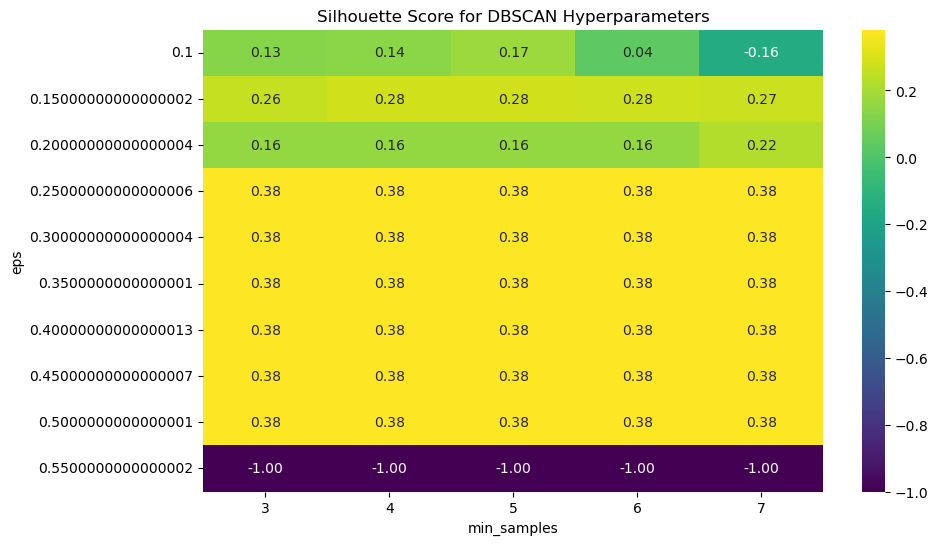

In [13]:
# Visualize silhouette scores for different hyperparameter combinations
pivot = results_df.pivot(
    index='eps'
    , columns='min_samples'
    , values='silhouette_score'
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot
    , annot=True
    , fmt=".2f"
    , cmap='viridis'
)
plt.title('Silhouette Score for DBSCAN Hyperparameters')
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.show();

In [14]:
# Pick the set with the highest silhouette score
best_result = results_df.loc[results_df['silhouette_score'].idxmax()]
best_eps = best_result['eps']
best_min_samples = best_result['min_samples']

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}")

Best eps: 0.25000000000000006, Best min_samples: 3.0


In [15]:
# Fit DBSCAN with the chosen hyperparameters
dbscan_best = DBSCAN(
    eps=best_eps
    , min_samples=int(best_min_samples)
).fit(df[['feature_1', 'feature_2']])

df['dbscan_label'] = dbscan_best.labels_

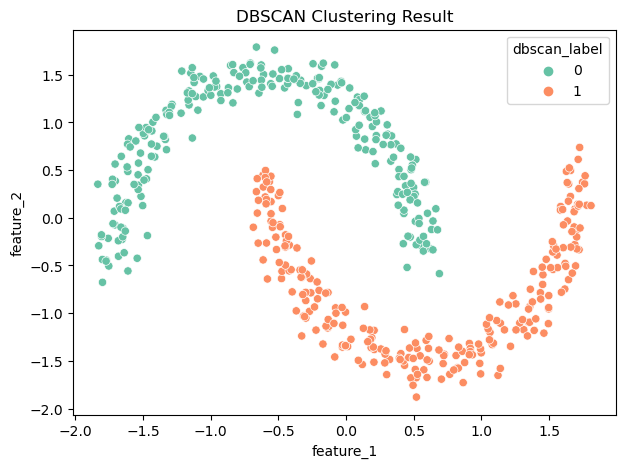

In [16]:
# Visualize the clustering result
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x='feature_1'
    , y='feature_2'
    , hue='dbscan_label'
    , palette='Set2'
    , data=df
    , legend='full'
)
plt.title('DBSCAN Clustering Result')
plt.show();

In [17]:
# Compute final silhouette score (ignoring noise points, label = -1)
labels = df['dbscan_label']
mask = labels != -1

final_score = silhouette_score(
    df.loc[mask, ['feature_1', 'feature_2']]
    , labels[mask]
)

print(f"Final Silhouette Score (excluding noise): {final_score:.2f}")
print(f"Number of clusters found: {len(set(labels)) - (1 if -1 in labels else 0)}")
print(f"Number of noise points: {(labels == -1).sum()}")

Final Silhouette Score (excluding noise): 0.38
Number of clusters found: 2
Number of noise points: 0
